In [1]:
import numpy as np
import pyvista as pv
from pyvista import examples
from icosphere import icosphere
from scipy.sparse import csc_array, csc_matrix, identity
from scipy.sparse.linalg import spsolve 
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
import pymeshfix as mf
from mpl_toolkits.mplot3d import Axes3D


from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d.art3d import pathpatch_2d_to_3d

WARNING- 1113 isolated vertices have been removed.


INFO- Loaded 35947 vertices and 69451 faces.
Patching holes...
Patched 5 holes
Fixing degeneracies and intersections

100% done 
INFO- ********* ITERATION 0 *********
INFO- Removing degeneracies...
INFO- Removing self-intersections...

99 % done   
INFO- No intersections detected.
Source 1 position in V:  [-0.62496699  1.49081007 -0.13576   ] Index 12816
Source 2 positipn in V:  [-0.34508102  0.83202504  0.425625  ] Index 4238


/Users/ahmedahmed/anaconda3/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


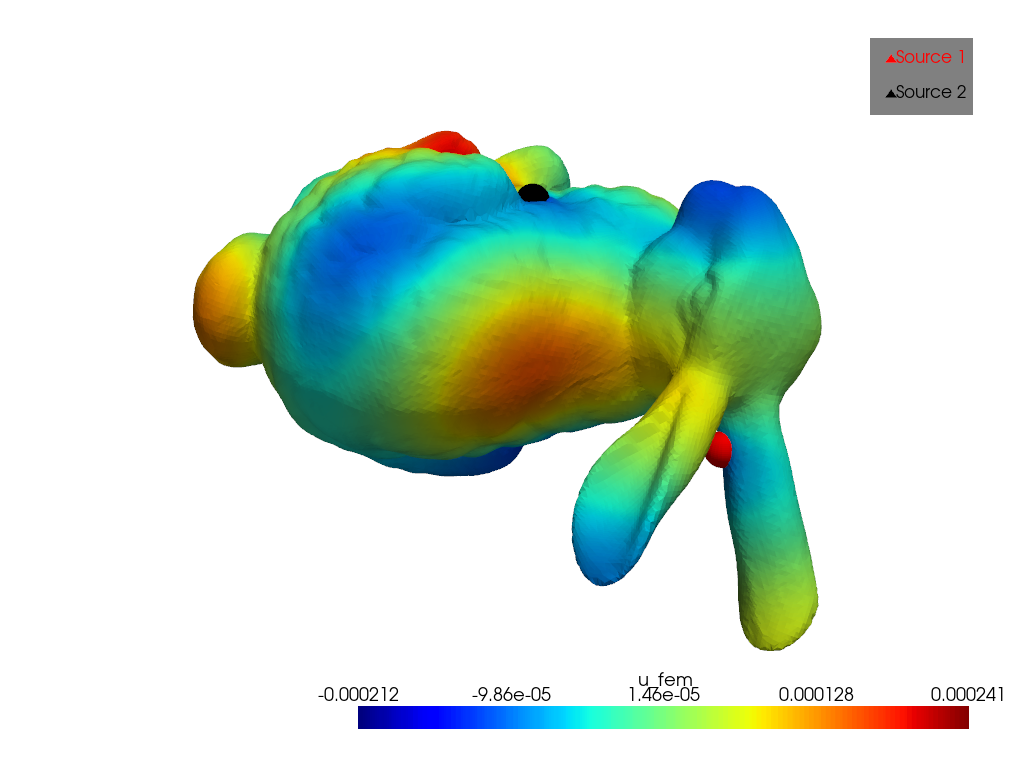

INFO- Loaded 35947 vertices and 69451 faces.
Patching holes...

100% done 
Patched 5 holes
Fixing degeneracies and intersections
INFO- ********* ITERATION 0 *********
INFO- Removing degeneracies...


WARNING- 1113 isolated vertices have been removed.


INFO- Removing self-intersections...

99 % done   
INFO- No intersections detected.
Source 1 position in V:  [-0.62496699  1.49081007 -0.13576   ] Index 12816
Source 2 positipn in V:  [-0.34508102  0.83202504  0.425625  ] Index 4238


/Users/ahmedahmed/anaconda3/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


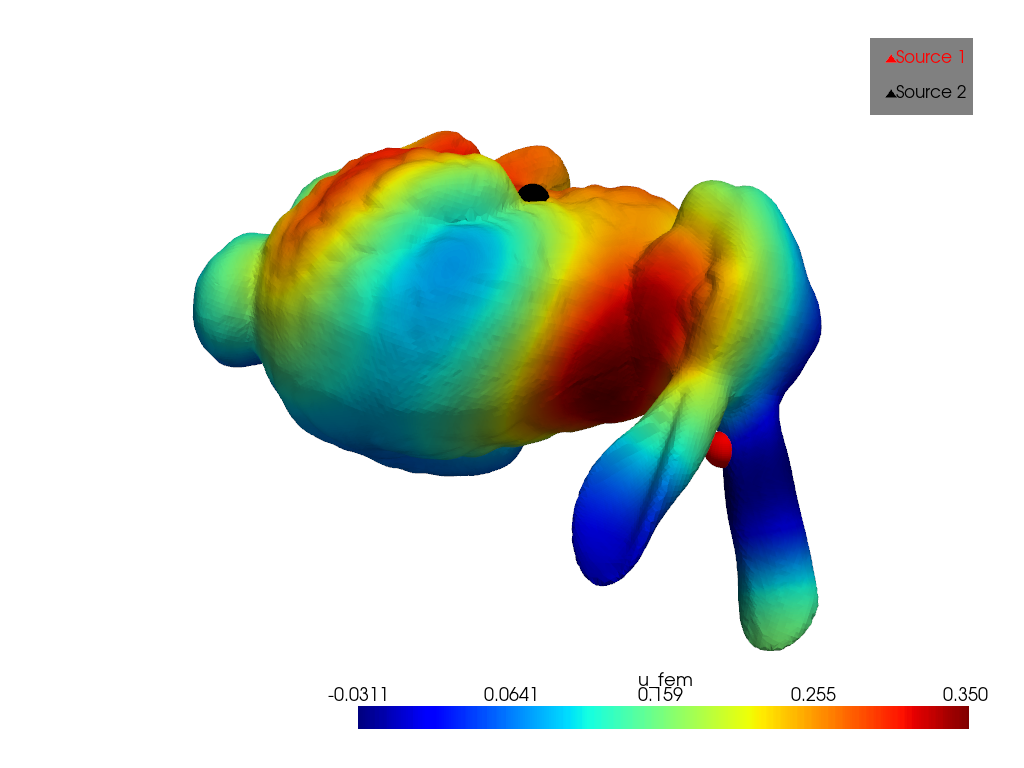

In [2]:
def cartestian2Spherical(xyz):
    rthph = np.zeros(xyz.shape)
    r = np.sqrt(xyz[:,0]**2 + xyz[:,1]**2 + xyz[:,2]**2)
    rthph[:,0] = r#Radius
    rthph[:,1] = np.arctan2(xyz[:,1], xyz[:,0])#Azimuth angle 
    rthph[:,2] = np.arccos(xyz[:,2]/r)#Elevation angle defined downward from +z-axis
    return rthph

def generateLocalSMN(vert_arr, tri_arr, k, omega):
    k_arr = tri_arr[k,:]
    r1 = vert_arr[k_arr[0],:]
    r2 = vert_arr[k_arr[1],:]
    r3 = vert_arr[k_arr[2],:]
    #Get edges
    E1 = r2 - r3
    E2 = r3 - r1
    E3 = r1 - r2
    A = 0.5*np.linalg.norm(np.cross(E1,E2))
    Sk = np.zeros((3,3), dtype=np.double)
    Mk = np.zeros((3,3), dtype=np.double)
    if A > 0:
        Sk = (1.0/(4.0*A))*np.array([[np.dot(E1,E1),np.dot(E1,E2), np.dot(E1,E3)],
                                     [np.dot(E2,E1),np.dot(E2,E2), np.dot(E2,E3)],
                                     [np.dot(E3,E1),np.dot(E3,E2), np.dot(E3,E3)]], dtype=np.double)
        Mk = (A/12.0)*np.array([[2,1,1],[1,2,1],[1,1,2]], dtype=np.double)
        Nk = (omega**2)*(A/12.0)*np.array([[2,1,1],[1,2,1],[1,1,2]], dtype=np.double)
    return k_arr, (-1.0*Sk), Mk, Nk

def generateSMSparse(vert_arr, tri_arr, omega):
    N_v = vert_arr.shape[0]
    V_S = []
    V_M = []
    I = []
    J = []
    for k in np.arange(tri_arr.shape[0]): 
        k_arr, Sk, Mk, Nk = generateLocalSMN(vert_arr, tri_arr, k, omega)
        for i in np.arange(3):
            for j in np.arange(3):
                V_S.append(Sk[i][j] + Nk[i][j])
                I.append(int(k_arr[i]))
                J.append(int(k_arr[j]))
                V_M.append(Mk[i][j])

    S = csc_matrix((np.array(V_S, dtype=np.double), (np.array(I, dtype=int),np.array(J, dtype=int))), shape=(N_v, N_v), dtype=np.double)
    M = csc_matrix((np.array(V_M, dtype=np.double), (np.array(I, dtype=int),np.array(J, dtype=int))), shape=(N_v, N_v), dtype=np.double)
    return S,M


def plotSolution(V, faces, u_fem, source_idx1, source_idx2):
    # Create a PyVista mesh object
    mesh = pv.PolyData(V, faces)
    mesh['u_fem'] = u_fem  # Add your data to the mesh

    # Create plotting object and add the mesh
    plotter = pv.Plotter()
    plotter.add_mesh(mesh, scalars='u_fem', cmap='jet', show_edges=False)

    # Highlight the source location with a larger, red sphere
    # Source 1:  [-0.53876001  1.26919001  0.361236  ]
    # Source 2:  [-0.77993497  1.71503007 -0.37948798]

    source_sphere = pv.Sphere(radius=0.05, center=V[source_idx1])
    source_sphere2 = pv.Sphere(radius=0.05, center=V[source_idx2])
    plotter.add_mesh(source_sphere, color='red')
    plotter.add_mesh(source_sphere2, color='k')

    # Adjust camera position and zoom
    # plotter.view_isometric()

    plotter.camera_position = [0.5,  1.2,  0.5]
    plotter.camera.zoom(1.2)

    # Show the plotter
    # Add the legend with specified font size
    plotter.add_legend(labels=[('Source 1', 'red'), ('Source 2', 'black')], size=(0.1, 0.1))

    plotter.show()

"""
For comparison I fixed the source locations
Source 1 position in V:  [-0.62496699  1.49081007 -0.13576   ] Index 12816
Source 2 positipn in V:  [-0.34508102  0.83202504  0.425625  ] Index 4238
"""

def solveBunny_DiracSrc(omega):
    mesh_bun_holes = examples.download_bunny().triangulate()
    mesh_bun = mf.MeshFix(mesh_bun_holes)
    mesh_bun.repair(verbose=True)
    meshb = mesh_bun.mesh
    V = 10.0*meshb.points
    T = meshb.faces.reshape((-1,4))[:,1:]
    S,M = generateSMSparse(V,T, omega)#Generate sparse FEM stiffness and mass matrices
    # PyVista requires faces to start with the number of points in each face
    faces = np.hstack((np.full((T.shape[0], 1), 3, dtype=T.dtype), T)).ravel()
    f = np.zeros(V.shape[0])
    diracDeltaIdx1 = 12816 #np.random.randint(low=0,high=V.shape[0])
    f[diracDeltaIdx1] = 2.0
    diracDeltaIdx2 = 4238 #np.random.randint(low=0,high=V.shape[0])
    f[diracDeltaIdx2] = 2.0
    
    print("Source 1 position in V: ", V[diracDeltaIdx1], "Index", diracDeltaIdx1)
    print("Source 2 positipn in V: ", V[diracDeltaIdx2], "Index", diracDeltaIdx2)

    epsilon = 1.0e-8
    A = S + (epsilon*identity(V.shape[0], dtype=np.double, format="csc"))
    b = M.dot(f)
    u = spsolve(A,b)
    plotSolution(V, faces, u, diracDeltaIdx1, diracDeltaIdx2)

def gaussian_source(position, center, exp10):
    """
    Compute the Gaussian value at a given position.
    exp10: Scaling factor for the Gaussian.
    """
    x, y, z = position - center
    return exp10 * np.exp(-(x**2 + y**2 + z**2))

def solveBunny_DiracGaussSrc(omega):
    mesh_bun_holes = examples.download_bunny().triangulate()
    mesh_bun = mf.MeshFix(mesh_bun_holes)
    mesh_bun.repair(verbose=True)
    meshb = mesh_bun.mesh
    #meshb['scalars'] = [np.linalg.norm(pt) for pt in meshb.points]
    #meshb.plot()
    V = 10.0*meshb.points
    T = meshb.faces.reshape((-1,4))[:,1:]
    S,M = generateSMSparse(V,T, omega)#Generate sparse FEM stiffness and mass matrices
    # PyVista requires faces to start with the number of points in each face
    faces = np.hstack((np.full((T.shape[0], 1), 3, dtype=T.dtype), T)).ravel()
    f = np.zeros(V.shape[0])
    diracDeltaIdx1 = 12816 #np.random.randint(low=0,high=V.shape[0])
    gaussianCenterIdx = 4238 #np.random.randint(low=0, high=V.shape[0])

    f[diracDeltaIdx1] = 2.0
    for i in range(V.shape[0]):
        f[i] += gaussian_source(V[i], V[gaussianCenterIdx], exp10=10.0)

    print("Source 1 position in V: ", V[diracDeltaIdx1], "Index", diracDeltaIdx1)
    print("Source 2 positipn in V: ", V[gaussianCenterIdx], "Index", gaussianCenterIdx)

    epsilon = 1.0e-8
    A = S + (epsilon*identity(V.shape[0], dtype=np.double, format="csc"))
    b = M.dot(f)
    u = spsolve(A,b)
    plotSolution(V, faces, u, diracDeltaIdx1, gaussianCenterIdx)

def main():
    omega = 2.0*np.pi
    solveBunny_DiracSrc(omega)
    solveBunny_DiracGaussSrc(omega)

if __name__ == "__main__":
    main()

Source 1 position in V:  [-0.39876599  1.13890998 -0.165093  ] Index 24151
Source 2 positipn in V:  [0.54459602 0.58178    0.27656799] Index 8467

Source 1 position in V:  [ 0.41786902  0.88692002 -0.0877741 ] Index 3141
Source 2 positipn in V:  [0.45431402 0.88986002 0.031764  ] Index 8705

Source 1 position in V:  [0.25105599 0.902557   0.46982098] Index 11120
Source 2 positipn in V:  [-0.59859902  0.35888799  0.45495398] Index 22625

Source 1 position in V:  [-0.17433099  0.62591299  0.51790901] Index 18854
Source 2 positipn in V:  [-0.65324597  0.64809702  0.284194  ] Index 31472
